In [1]:
from scipy import interpolate
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from model import DNN
from inverse_config import G, glad, mu_h, Pk, L, k
from inverse_utils import mu_oil

### interpolation

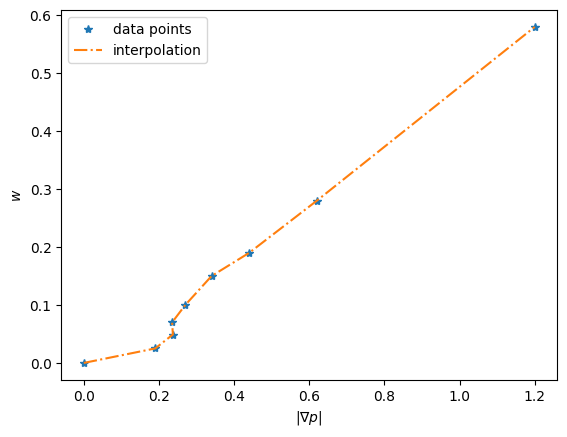

In [2]:
velocity = np.loadtxt("data/W.txt", delimiter='\t', dtype=np.float64)
gradient = np.loadtxt("data/grad.txt", delimiter='\t', dtype=np.float64)

velocity = velocity[:-3]*1e7  # W*1e+7 m/s*1e+7
gradient = gradient[:-3]/1e5 # atm/m

velocity[0] = 0
gradient[0] = 0

f = interpolate.interp1d(gradient, velocity)

plt.plot(gradient, velocity, '*', label = 'data points')
plt.plot(gradient, f(gradient), '-.', label = 'interpolation')
plt.legend()
plt.xlabel(r"$|\nabla p|$")
plt.ylabel(r'$w$')
plt.show()

### train model

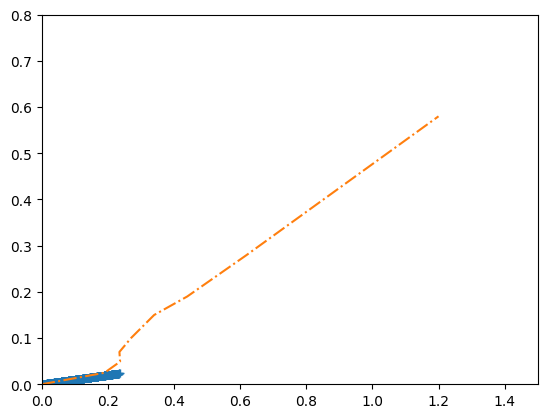

epoch 2000: loss 1.662534
G 183567.21848249435
glad 0.0019232650995254516
mu_h 0.024997186660766602


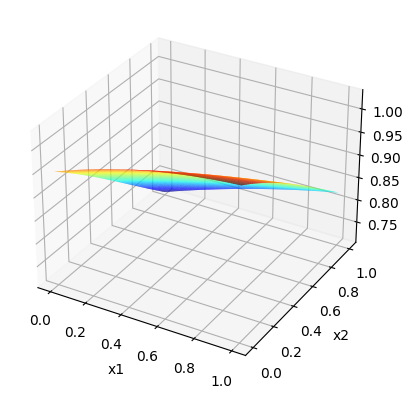

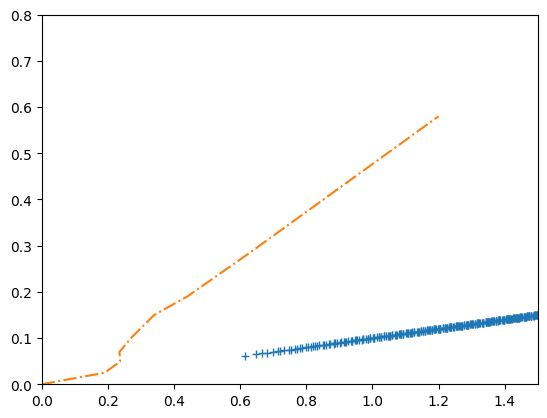

epoch 4000: loss 0.579151
G 169814.0986263752
glad 0.001822862148284912
mu_h 0.024997186660766602


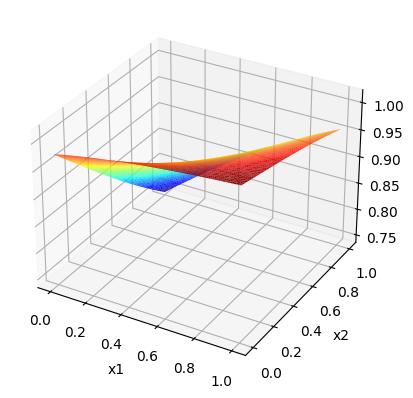

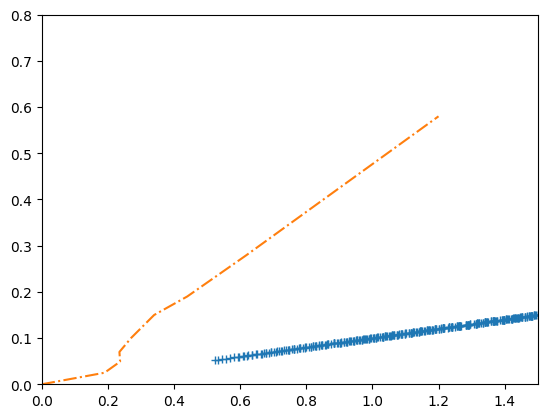

epoch 6000: loss 0.097907
G 131458.0999314785
glad 0.0017694604396820068
mu_h 0.024996824264526367


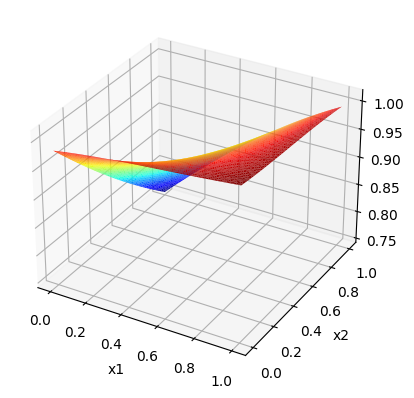

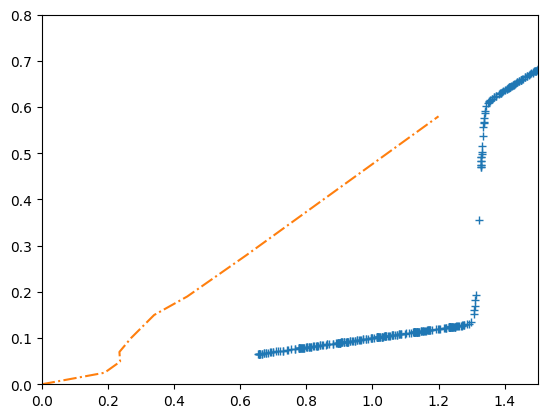

epoch 8000: loss 0.491274
G 108388.46676051617
glad 0.0017209794521331789
mu_h 0.024993309020996095


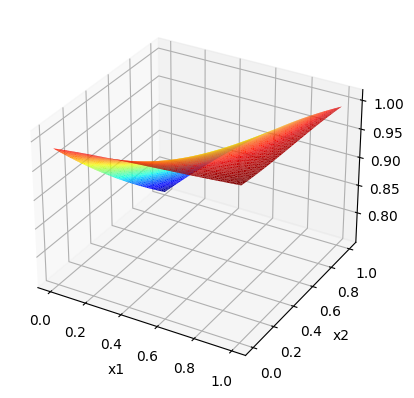

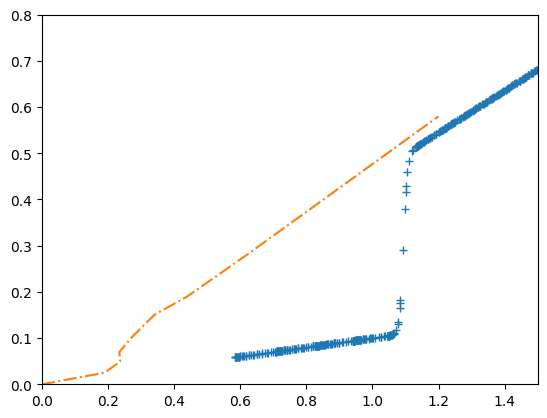

epoch 10000: loss 0.081038
G 82250.69381296635
glad 0.0016895366907119752
mu_h 0.024984540939331057


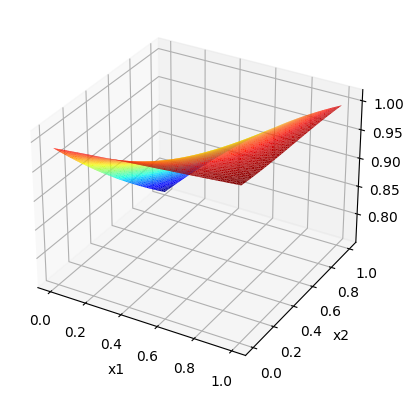

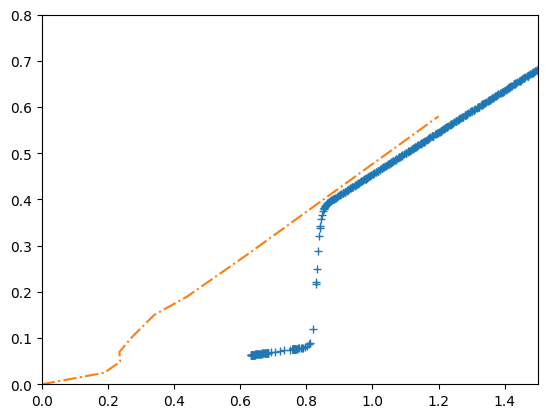

epoch 12000: loss 0.073973
G 68071.00027799606
glad 0.00167807674407959
mu_h 0.02496136474609375


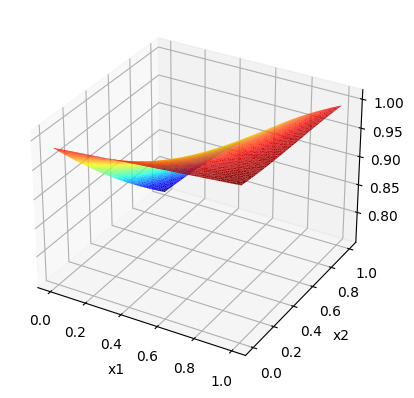

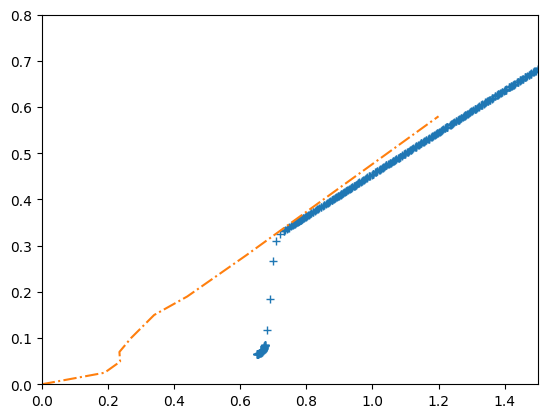

epoch 14000: loss 0.012899
G 24039.605632424355
glad 0.0015935015678405762
mu_h 0.02494876480102539


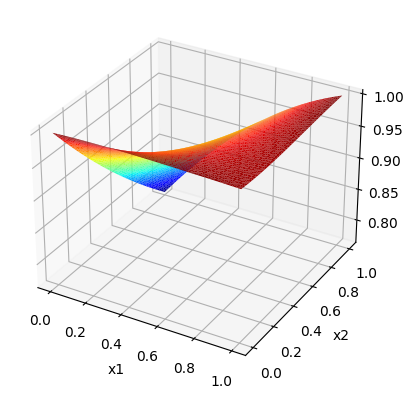

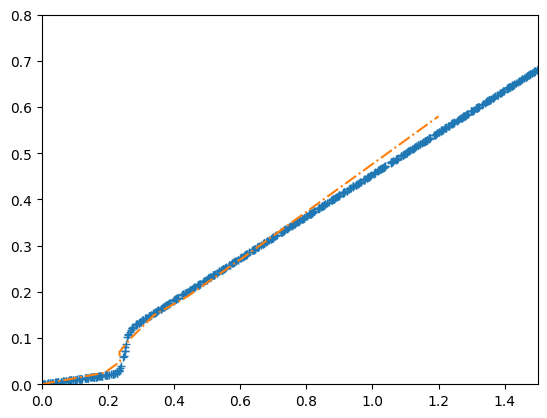

epoch 16000: loss 0.015288
G 23645.52579820156
glad 0.001384836792945862
mu_h 0.024947906494140627


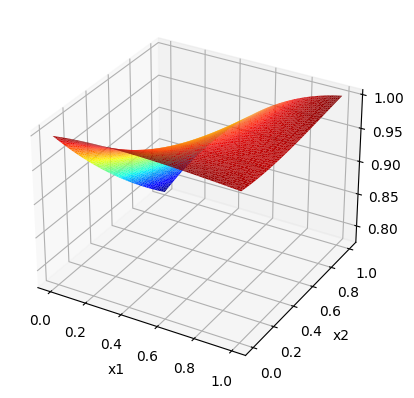

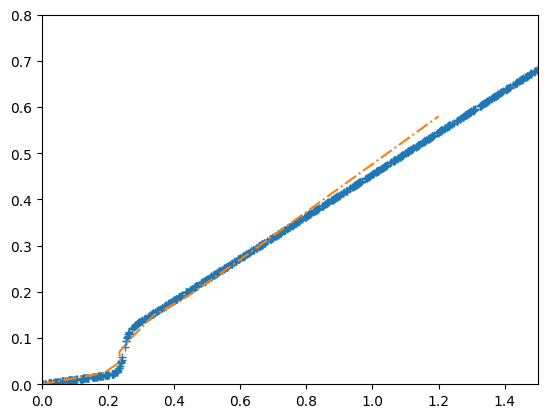

epoch 18000: loss 0.024409
G 22149.38635006547
glad 0.001104944348335266
mu_h 0.024941905975341797


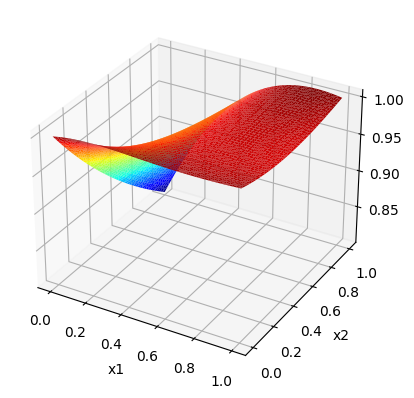

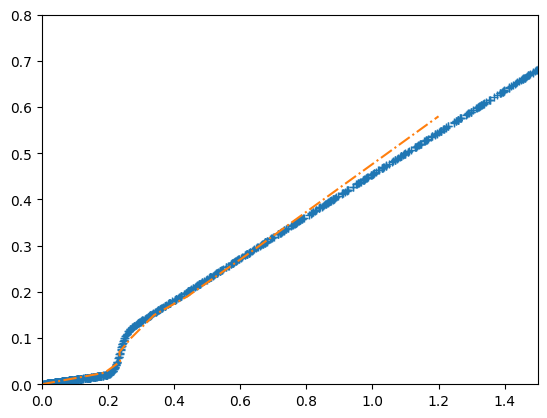

epoch 20000: loss 0.026187
G 22283.03113952279
glad 0.0008864973783493042
mu_h 0.0249261589050293


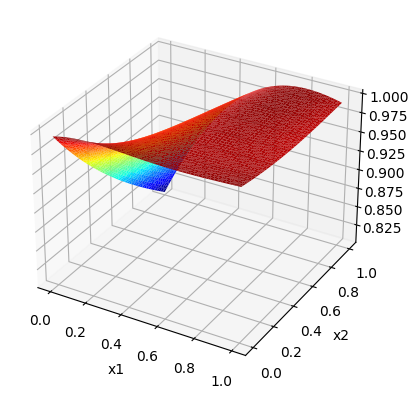

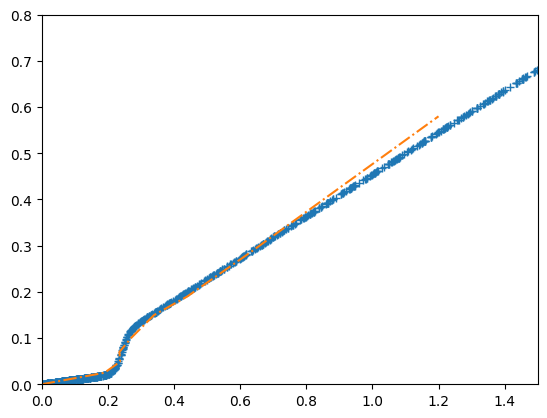

epoch 22000: loss 0.019277
G 21619.496401399374
glad 0.0006743620634078979
mu_h 0.02488541030883789


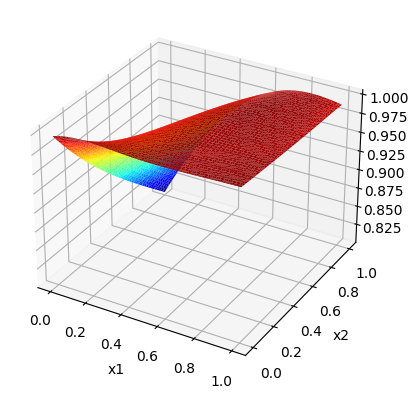

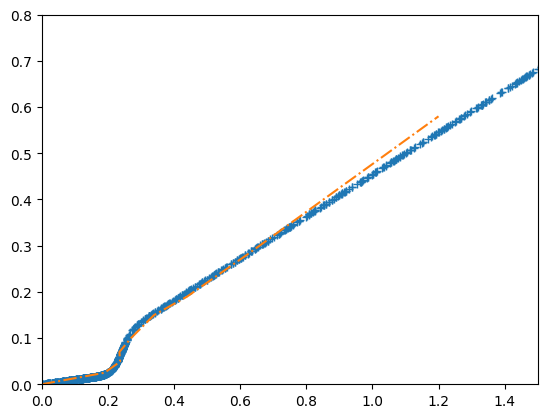

epoch 24000: loss 0.015918
G 21043.43380779028
glad 0.0004658108949661255
mu_h 0.024804393768310548


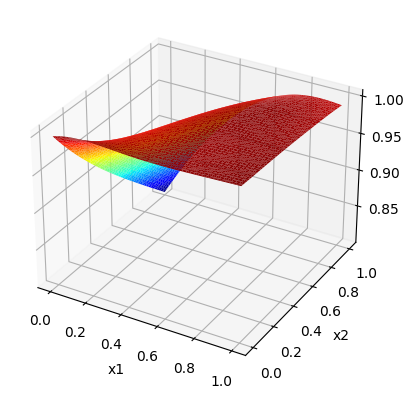

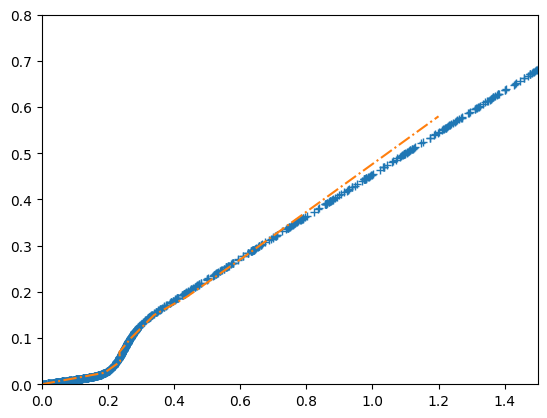

epoch 26000: loss 0.010883
G 19171.632593497634
glad 0.0003078010976314545
mu_h 0.02473105049133301


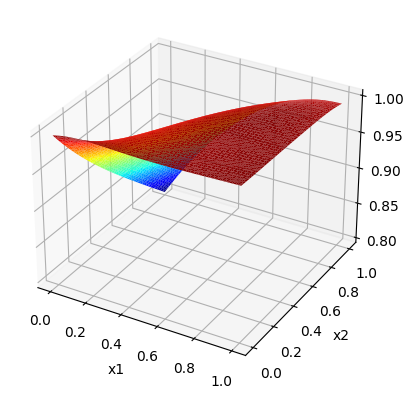

In [3]:
device = torch.device('cuda')

lr = 0.0001
epochs = 26000

u = torch.linspace(0, 1, 50)
t = torch.linspace(0, 1, 50)
###
grid = torch.cartesian_prod(u,t).float().to(device)

# p(u,0)=1
bnd1 = torch.cartesian_prod(u, torch.tensor([0.])).float().to(device)
bndval1 = torch.tensor([1.]).to(device)

#bnd2(u(-1), t)=1
bnd2 = torch.cartesian_prod(torch.tensor([1.]), t).float().to(device)
bndval2 = torch.tensor([1.]).to(device)

#bnd3
bnd3 = torch.cartesian_prod(torch.tensor([0.]), t).float().to(device)

#bnd4
bnd4 = grid
bndval4 = f

NN = torch.nn.Sequential(
            torch.nn.Linear(2, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 1))


# Initialize neural network
model = DNN(NN, G, glad, mu_h).to(device)


# Loss and optimizer
optimizer = torch.optim.Adam(model.net.parameters(), lr)


# Train PINNs
for epoch in range(1, epochs+1):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss_pde = model.loss_pde(grid)
        loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
        loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
        loss_bnd3 = model.loss_operator(bnd3).reshape(-1)
        loss_data = model.loss_data(bnd4, gradient, bndval4)
        if type(loss_data) is float:
            loss_data = 0
        else:
            loss_data = (loss_data).mean()
        loss = loss_pde + 1000*loss_bnd1.mean() + 100*(torch.hstack([loss_bnd2, loss_bnd3])).mean() + 10*loss_data

        loss.backward()
        return loss


    # Optimize loss function
    loss_pde = optimizer.step(closure)

    loss_value = loss_pde.item() if not isinstance(loss_pde, float) else loss_pde

    if epoch%2000==0:
        print(f'epoch {epoch}: loss {loss_value:.6f}')
        print('G', model.G.detach().item()*Pk/L)
        print('glad', model.glad.detach().item()*1e-3)
        print('mu_h', model.mu_h.detach().item()*1e-3)
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(projection='3d')
        ax1.plot_trisurf(grid[:, 0].cpu().detach().numpy().reshape(-1), grid[:, 1].cpu().detach().numpy().reshape(-1),
                    model(grid).cpu().detach().numpy().reshape(-1), cmap=cm.jet, linewidth=0.2, alpha=1)
        ax1.set_xlabel("x1")
        ax1.set_ylabel("x2")
        plt.show()


### graphs for velocity and viscosity

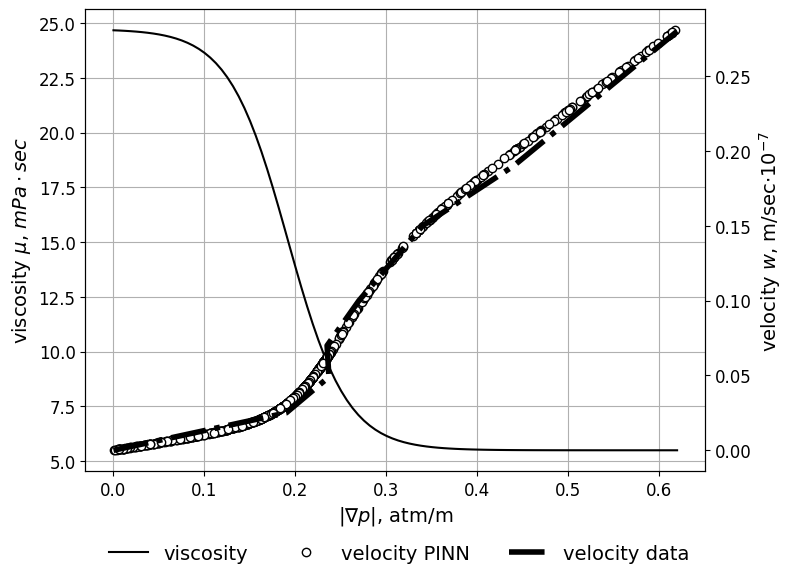

In [8]:
import matplotlib

font = {'serif' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

G = model.G.detach().item()
glad = model.glad.detach().item()
mu_h = model.mu_h.detach().item()
grad_mu = torch.linspace(0,0.62,100)


fig,ax = plt.subplots(figsize=(8,6))
ax.plot(grad_mu, mu_oil(grad_mu*L/Pk*1e5, G, glad, mu_h)/1e-3,c='k', mfc='w', mec='k',ms=6, label='viscosity')
ax2 = ax.twinx ()
ax2.plot(model.dp_grad[-1], model.velocity[-1], 'o', c='k', mfc='w', mec='k',ms=6, label = 'velocity PINN')
ax2.plot(gradient[:-1], f(gradient[:-1]), '-.', c='k', lw=4, label = 'velocity data')
ax.grid()
ax.set_xlabel(r'$|\nabla p|$, atm/m', fontsize=14)
ax.set_ylabel('viscosity $\mu$, $mPa\cdot sec$', fontsize=14)
ax2.set_ylabel('velocity $w$, m/sec$\cdot 10^{-7}$', fontsize=14)
ax.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.15, -0.12), ncol=1)
ax2.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.65, -0.12), ncol=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('mu_w_grad.eps', format='eps', bbox_inches="tight", dpi=1000)
plt.show()


In [5]:
G

0.007487733382731676